In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        
        classes = os.listdir(data_dir)
        
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.images.append(image_path)
                self.labels.append(i)
        
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.images)


In [3]:
working_directory='/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/'

In [4]:
train_dataset = ImageDataset(os.path.join(working_directory, 'Training'), transform=transform)
validate_data = ImageDataset(os.path.join(working_directory, 'validate'), transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(validate_data, batch_size=32, shuffle=False)

In [5]:
# Definir la arquitectura de la red convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 32 * 32, 4)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


model = SimpleCNN()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Entrenamiento del modelo
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        
        outputs = model(images)
        
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test images: {accuracy} %')

Epoch [1/10], Loss: 0.37949371337890625
Epoch [2/10], Loss: 0.22029085457324982
Epoch [3/10], Loss: 0.30310705304145813
Epoch [4/10], Loss: 0.29945799708366394
Epoch [5/10], Loss: 0.10680918395519257
Epoch [6/10], Loss: 0.1693183332681656
Epoch [7/10], Loss: 0.08088744431734085
Epoch [8/10], Loss: 0.16408944129943848
Epoch [9/10], Loss: 0.055533517152071
Epoch [10/10], Loss: 0.09063694626092911
Accuracy on test images: 93.82151029748283 %


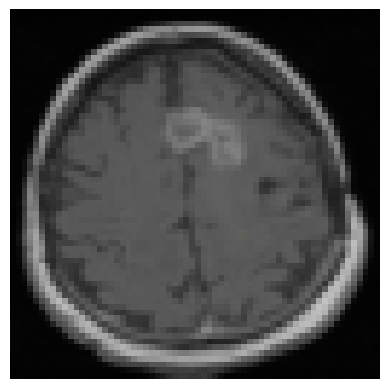

Prediction 1: pituitary, Probability: 0.9686060547828674
Prediction 2: meningioma, Probability: 0.029997818171977997
Prediction 3: glioma, Probability: 0.00139032700099051


In [7]:
image_path = '/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/Testing/glioma.jpg'  
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0) 

inv_transform = transforms.Compose([
    transforms.Normalize((-1,), (2,)),  
    transforms.ToPILImage()  
])
inv_image = inv_transform(image_tensor.squeeze())

import matplotlib.pyplot as plt

plt.imshow(inv_image)
plt.axis('off')
plt.show()

with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.softmax(output, dim=1)
    top_probabilities, top_indices = torch.topk(probabilities, k=3)
    
classes = ['glioma', 'meningioma', 'no tumor', 'pituitary']
for i in range(3):
    print(f"Prediction {i+1}: {classes[top_indices[0][i]]}, Probability: {top_probabilities[0][i].item()}")

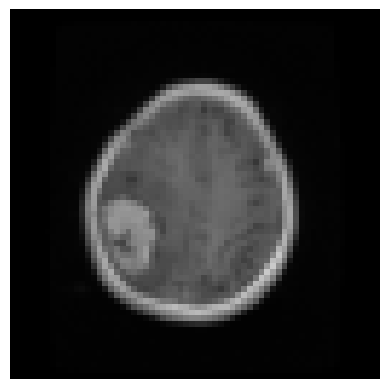

Prediction 1: pituitary, Probability: 0.9950487017631531
Prediction 2: no tumor, Probability: 0.004935428500175476
Prediction 3: meningioma, Probability: 1.5896395780146122e-05


In [8]:
# Cargar una imagen para la predicción
image_path = '/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/Testing/meningioma_3.jpg'  
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0) 

# Invertir las transformaciones y normalizaciones
inv_transform = transforms.Compose([
    transforms.Normalize((-1,), (2,)),  # Invierte la normalización
    transforms.ToPILImage()  # Convierte el tensor a imagen PIL
])
inv_image = inv_transform(image_tensor.squeeze())

# Mostrar la imagen
import matplotlib.pyplot as plt

plt.imshow(inv_image)
plt.axis('off')
plt.show()

# Realizar la predicción
with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.softmax(output, dim=1)
    top_probabilities, top_indices = torch.topk(probabilities, k=3)
    
# Obtener las clasificaciones correspondientes
classes = ['glioma', 'meningioma', 'no tumor', 'pituitary']
for i in range(3):
    print(f"Prediction {i+1}: {classes[top_indices[0][i]]}, Probability: {top_probabilities[0][i].item()}")

# interesante que el modelo tampoco es preciso, aun con porcentajes realmente alto de precision, que raro, por qeu sera?